# Gym Crowdedness Prediction<a id='top'></a>
&emsp;This [Dataquest guided project](https://app.dataquest.io/c/137/m/750/guided-project%3A-stochastic-gradient-descent-on-linear-regression/1/stochastic-gradient-descent-on-linear-regression) will utilize Stochastic Gradient Descent algorithm to establish the best fitted line which hopefully could accurately predict the crowdedness of the gym in given parameters.

1. [Data Exploration](#explore)  
  1.1 [Distributions](#distributions)  
  1.2 [Relationship Among Features](#relationship)

In [568]:
# Libraries
# array and dataframe
import numpy as np
import pandas as pd
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use("fivethirtyeight")
# data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# model
from sklearn.linear_model import SGDRegressor
# evaluation
from sklearn.metrics import mean_squared_error

# Data Exploration<a id='explore'></a>

In [569]:
gym = pd.read_csv("crowdedness.csv")
# Check feature types
print(gym.shape)
print(gym.dtypes)
gym.head(2)

(62184, 11)
number_people             int64
date                     object
timestamp                 int64
day_of_week               int64
is_weekend                int64
is_holiday                int64
temperature             float64
is_start_of_semester      int64
is_during_semester        int64
month                     int64
hour                      int64
dtype: object


,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17


In [570]:
# Check missing values
gym.isna().sum().sum()

0

&emsp;The *timestamp* feature contains hour, minute, and second. However, it seems unnecessary to distinguish the difference in number of people within an hour time frame. So the feature *hour* can replace *timestamp*. Besides, *year* and *day* are extracted from *date*.

In [571]:
gym['day'] = gym['date'].str[8:10]
gym['year'] = gym['date'].str[:4]
# Extract year-month for trend overview
gym['yyyymm'] = gym.apply(lambda x: x['year'] + str(x['month']) if len(str(x['month']))==2 else x['year'] + "0" + str(x['month']), axis=1)
gym.drop(columns=['timestamp','date'], inplace=True)
gym[['day', 'year', 'yyyymm']] = gym[['day', 'year', 'yyyymm']].astype(int)
gym.head(2)

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,day,year,yyyymm
0,37,4,0,0,71.76,0,0,8,17,14,2015,201508
1,45,4,0,0,71.76,0,0,8,17,14,2015,201508


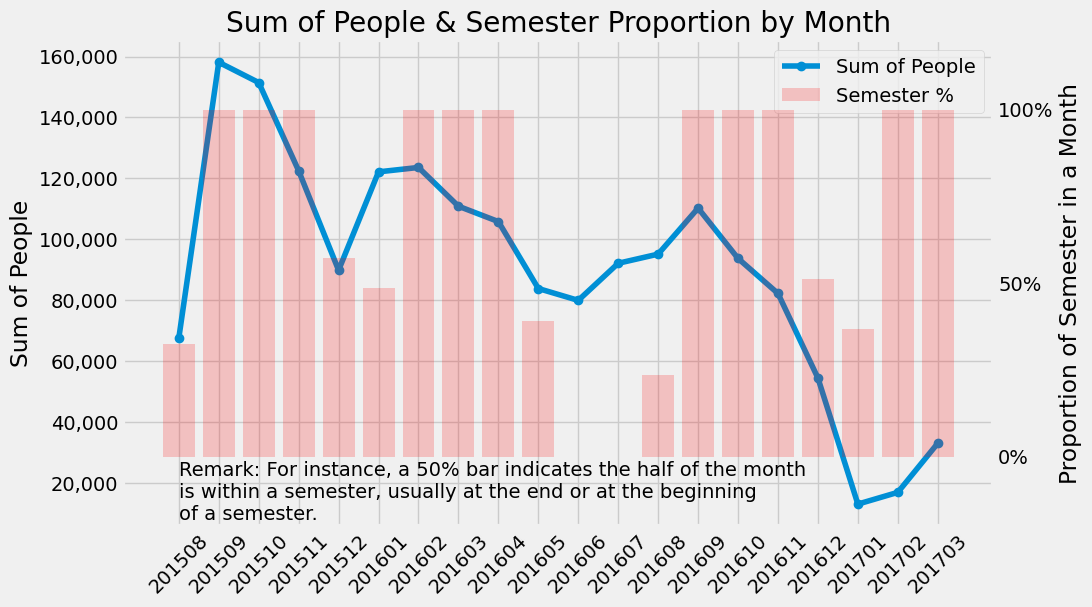

In [572]:
# Visualize trend over time
trend = gym.groupby('yyyymm')['number_people'].sum()
semester = gym.groupby('yyyymm')['is_during_semester'].mean()

fig, ax = plt.subplots(figsize=(10,6))
twin = ax.twinx()

ax.set_title("Sum of People & Semester Proportion by Month")

p1 = ax.plot([str(i) for i in trend.index], trend, marker='o', label='Sum of People')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xticks([str(i) for i in trend.index], [str(i) for i in trend.index], rotation=45)
ax.set(ylabel='Sum of People')
ax.grid(True)
ax.text("201508", 8000, "Remark: For instance, a 50% bar indicates the half of the month\nis within a semester, usually at the end or at the beginning\nof a semester.")

p2 = twin.bar([str(i) for i in semester.index], semester, alpha=.2, color='red', label='Semester %')
twin.set(ylim=(-.2,1.2), ylabel='Proportion of Semester in a Month')
twin.set_yticks([0, .5, 1])
twin.set_yticklabels(['0%', '50%', '100%'])
twin.grid(False)

ax.legend(handles=[p1[0],p2])
plt.show()

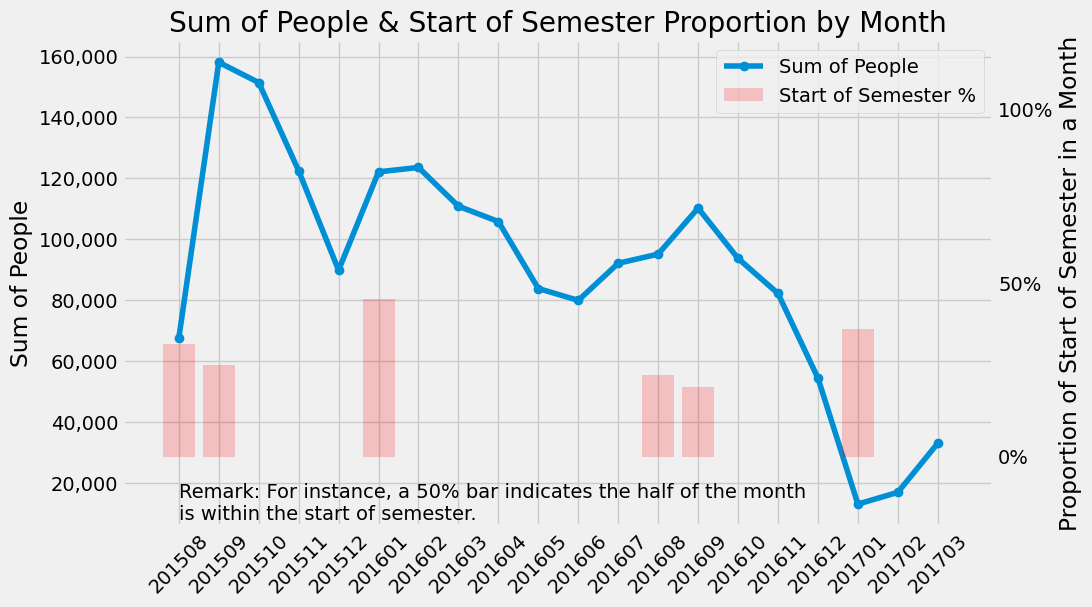

In [573]:
# Visualize trend over time
trend = gym.groupby('yyyymm')['number_people'].sum()
start_semester = gym.groupby('yyyymm')['is_start_of_semester'].mean()

fig, ax = plt.subplots(figsize=(10,6))
twin = ax.twinx()

ax.set_title("Sum of People & Start of Semester Proportion by Month")

p1 = ax.plot([str(i) for i in trend.index], trend, marker='o', label='Sum of People')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xticks([str(i) for i in trend.index], [str(i) for i in trend.index], rotation=45)
ax.set(ylabel='Sum of People')
ax.grid(True)
ax.text("201508", 8000, "Remark: For instance, a 50% bar indicates the half of the month\nis within the start of semester.")

p2 = twin.bar([str(i) for i in start_semester.index], start_semester, alpha=.2, color='red', label='Start of Semester %')
twin.set(ylim=(-.2,1.2), ylabel='Proportion of Start of Semester in a Month')
twin.set_yticks([0, .5, 1])
twin.set_yticklabels(['0%', '50%', '100%'])
twin.grid(False)

ax.legend(handles=[p1[0],p2])
plt.show()

&emsp;The 2 plots above show that there are always peaks during or soon after the start of a semester. During the semesters, the sum of people generally decreases until the end of the semesters.

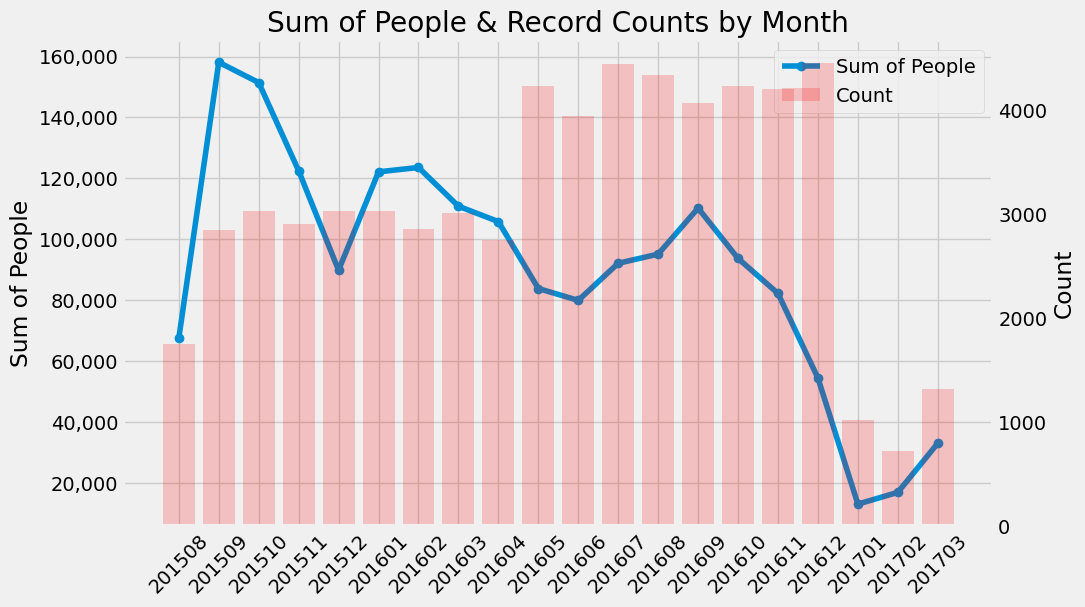

In [574]:
# Visualize trend over time
trend = gym.groupby('yyyymm')['number_people'].sum()
count = gym.groupby('yyyymm')['number_people'].size()

fig, ax = plt.subplots(figsize=(10,6))
twin = ax.twinx()

ax.set_title("Sum of People & Record Counts by Month")

p1 = ax.plot([str(i) for i in trend.index], trend, marker='o', label='Sum of People')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xticks([str(i) for i in trend.index], [str(i) for i in trend.index], rotation=45)
ax.set(ylabel='Sum of People')
ax.grid(True)
# ax.text("201508", 8000, "Remark: For instance, a 50% bar indicates the half of the month\nis within a semester, usually at the end or at the beginning\nof a semester.")

p2 = twin.bar([str(i) for i in count.index], count, alpha=.2, color='red', label='Count')
twin.set(ylabel='Count')
# twin.set_yticks([0, .5, 1])
# twin.set_yticklabels(['0%', '50%', '100%'])
twin.grid(False)

ax.legend(handles=[p1[0],p2])
plt.show()

&emsp;Regardless of the sum of people, the count of records is inconsistent. Partial data from the entire dataset may be considered to train, validate, and test the model. In the following preliminary data exploration, records from 201605 to 201612 will be used.

In [575]:
gym1 = gym[gym['yyyymm'].isin([y for y in range(201605,201613)])].reset_index(drop=True)
gym1.shape

(33902, 12)

## Distributions<a id='distributions'></a>

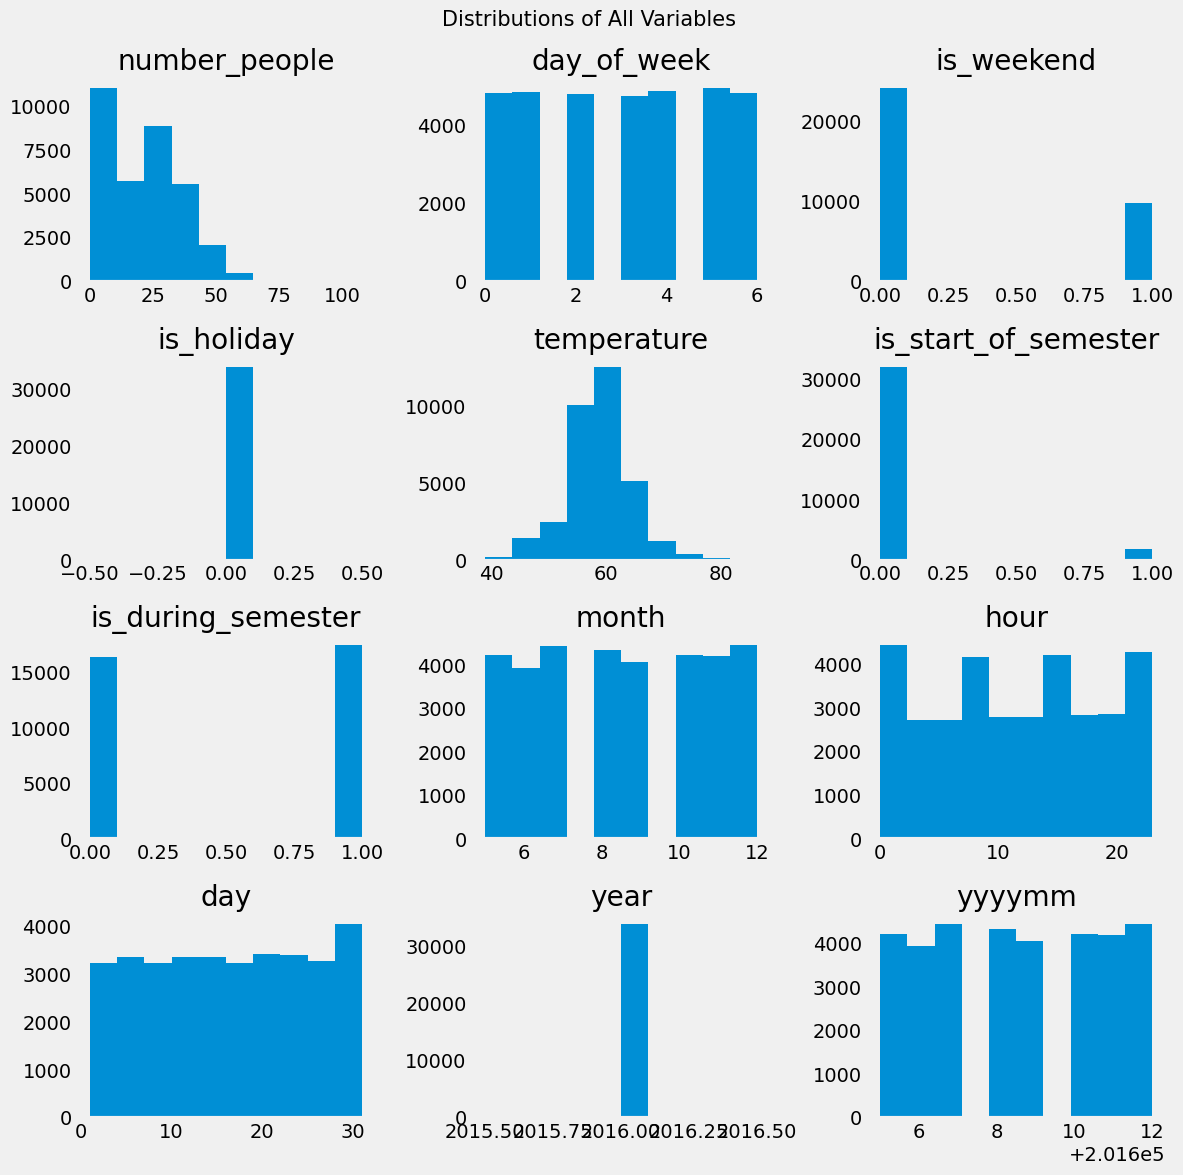

In [576]:
gym1.hist(grid=False, figsize=(12,12))
plt.suptitle("Distributions of All Variables", fontsize=15)
plt.tight_layout()
plt.show()

&emsp;The distributions appear to be reasonable. 

## Relationship Among Features<a id='relationships'></a>

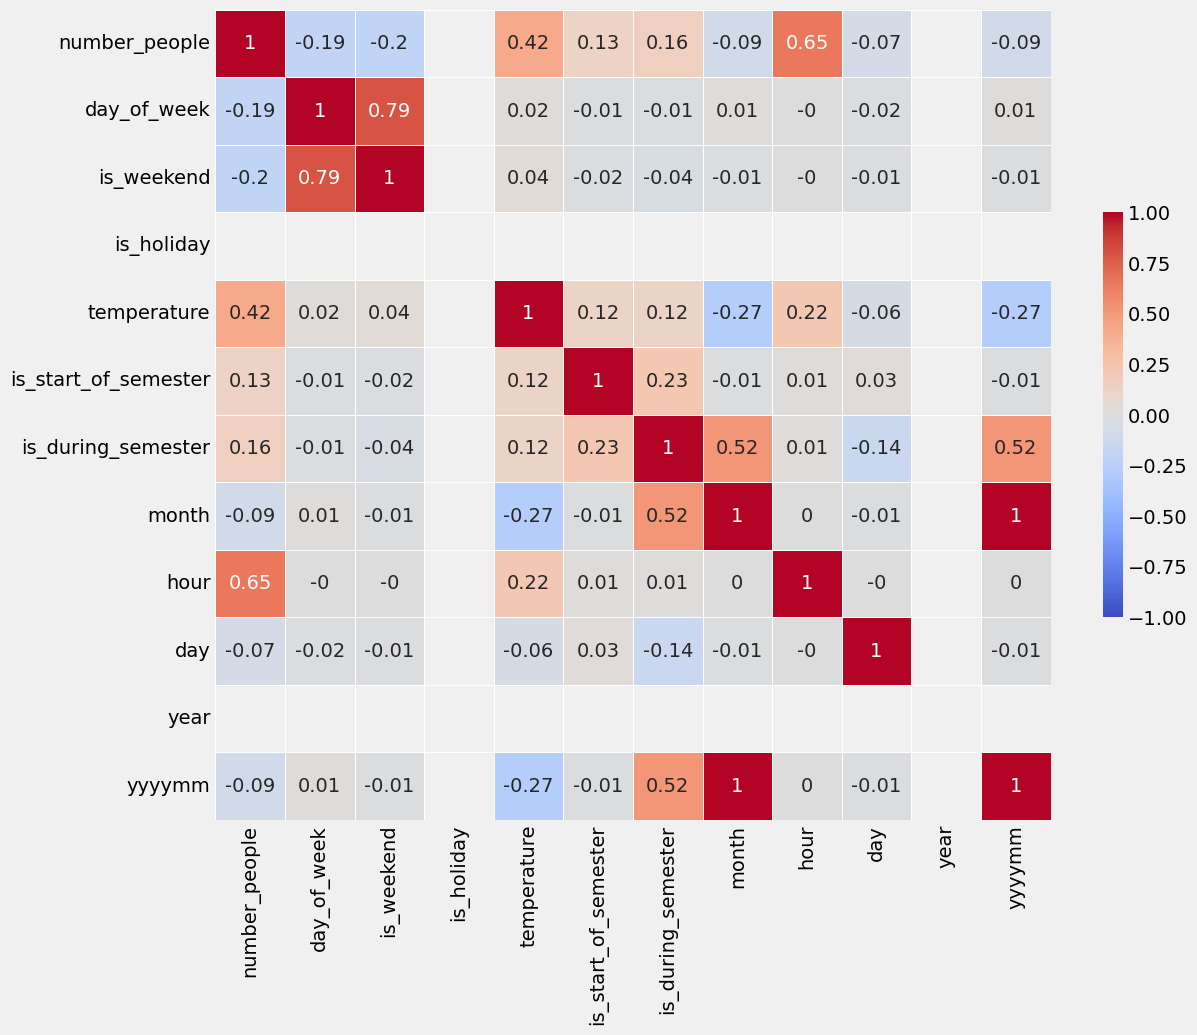

In [577]:
# Correlations without transformation
cor = round( gym1.loc[:,~gym1.columns.isin(['date'])].corr(), 2 )
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.grid(False)
plt.show()

The response variable (*number of people*) shows some relationship with  
* *day_of_week*  
* *is_weekend*  
* *temperature*  
* *hour*  

However, two more feature examinations need to be done before selection.  
* *month* is actually nominal values which would not show reliable relationship via correlation  
    * However, in this partial dataset with entire set of months, *month* will not be used in modelling.
* Previously, the line plot shows that gerally the *number of people* peaks at the beginning of a semester and gradually decreases until another peak. As a result, the feature *is_during_semester* will be divided into 6 values which are  
    * *sem_1*  
    * *sem_2*
    * *sem_3*
    * *sem_4*  
    * *sem_5*  
    * *summer*  
where *sem_1* represents the first month (roughly) of the semester whereas *sem_5* represents the last month of the semester. By looking at the previous plot, semesters start from August until December and from January until May. June and July are *summer* holiday.

In [578]:
# Assign semester session
def sem_split(month):
    if month in [8,1]:
        return 'sem_1'
    elif month in [9,2]:
        return 'sem_2'
    elif month in [10,3]:
        return 'sem_3'
    elif month in [11,4]:
        return 'sem_4'
    elif month in [12,5]:
        return 'sem_5'
    else:
        return 'summer'

In [579]:
# Create new feature
gym1['semester'] = gym1['month'].apply(sem_split)

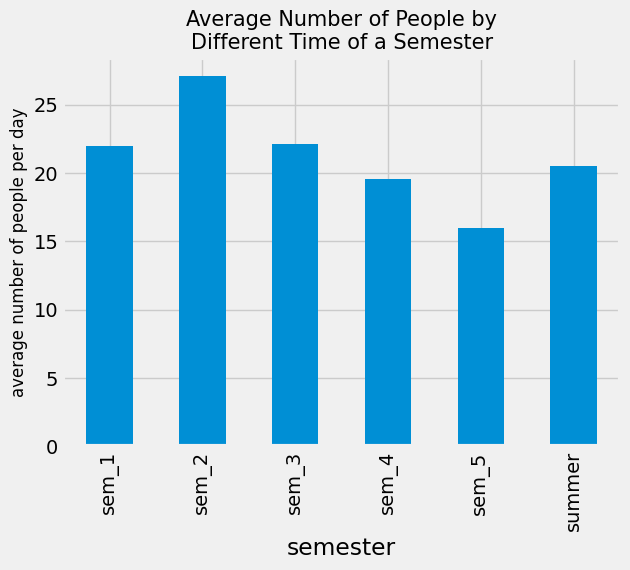

In [580]:
# Visualize new feature with response
sems = gym1.groupby('semester')['number_people'].mean().reset_index()
sems.plot.bar('semester', 'number_people', legend=False)
plt.ylabel("average number of people per day", fontsize=12)
plt.title("Average Number of People by\nDifferent Time of a Semester", fontsize=15)
plt.show()

The plot resembles previous observation. These values will be converted into dummy variables for model training.

In [581]:
hours = gym1.groupby('hour')['number_people'].mean().reset_index()
hours

,hour,number_people
0,0,10.510903
1,1,1.082807
2,2,0.172096
3,3,0.145184
4,4,0.288939
5,5,1.040389
6,6,7.466523
7,7,12.126346
8,8,18.906877
9,9,23.675986


In [ ]:
range(0:4)
range(4:8)
range(8:12)
range(12:16)
range(16:20)
range(20:24)